In [1]:
import numpy as np
import pandas as pd
import os
import glob
import joblib

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerBase
import seaborn as sns

from nilearn import plotting 
from nilearn.image import smooth_img, swap_img_hemispheres

from nilearn.input_data import NiftiMasker
import nibabel as nib

import scipy.stats
from scipy.stats import pearsonr, spearmanr, ttest_ind
import statsmodels.api as sm

import llms_brain_lateralization as lbl
from llms_brain_lateralization import make_dir

In [2]:
rc={'font.size': 12, 'axes.labelsize': 14, 
    'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(rc=rc)
sns.set_style('darkgrid')

In [3]:
save_fig = True

In [4]:
if save_fig:
    fig_folder = lbl.figures_folder
    make_dir(fig_folder)

In [5]:
nifti_masker = NiftiMasker(mask_img='mask_lpp_en.nii.gz')
nifti_masker.fit()

n_voxels = nifti_masker.n_elements_

In [6]:
glm_folder = lbl.llms_brain_correlations

In [7]:
df_model_info = pd.read_csv('model_info.csv', index_col=0)

In [8]:
model_names = df_model_info['model_name'].to_numpy()
n_parameters = df_model_info['n_parameters'].to_numpy()
n_layers_models = df_model_info['n_layers'].to_numpy()
ppl_models = df_model_info['ppl'].to_numpy()
hellaswag_models = df_model_info['hellaswag'].to_numpy()

idx_sort_params = np.argsort(n_parameters)

model_names = model_names[idx_sort_params]
n_layers_models = n_layers_models[idx_sort_params]
n_parameters = n_parameters[idx_sort_params]
ppl_models = ppl_models[idx_sort_params]
hellaswag_models = hellaswag_models[idx_sort_params]

In [9]:
n_models = len(model_names)

In [10]:
corr_layers_voxels_models = []
for model_name, n_layers in zip(model_names, n_layers_models):
    corr_layers_voxels = []
    for idx_layer in range(n_layers):
        filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, idx_layer))
        with open(filename, 'rb') as f:
            corr_voxels = joblib.load(f)
        corr_layers_voxels.append(corr_voxels)
    corr_layers_voxels_models.append(np.array(corr_layers_voxels))

In [11]:
color_models = list(sns.color_palette('plasma', n_colors=len(corr_layers_voxels_models)))

In [12]:
# mean correlation for each voxel, for each model, using best layer for each voxel
# n_models x n_voxels
corr_voxels_models = np.array([np.max(corr_layers_voxels, axis=0) for corr_layers_voxels in corr_layers_voxels_models])

# mean correlation for each model, using best layer for each voxel, averaged over all voxels
# n_voxels
corr_models = np.array([np.mean(corr_voxels) for corr_voxels in corr_voxels_models])

# mean correlation for each layer of each model, averaged over all voxels
# n_models x n_layers 
corr_layers_models = [np.mean(corr_layers, axis=1) for corr_layers in corr_layers_voxels_models]

# restrict to left and right hemisphere
corr_l_models = corr_voxels_models[:,:n_voxels//2]
corr_r_models = corr_voxels_models[:,n_voxels//2:]

In [13]:
# left: red, right: green (as for port and starboard; should be colorblind compatible though)
l_r_colors = sns.color_palette('colorblind', n_colors=4)[2:][::-1]

In [14]:
palette_family = sns.color_palette('Set2')
id_family = {'gpt':0, 'opt':1, 'Lla':3, 'Qwe':2, 'gem':6, 'sta':7, 'Mis':4, 'mam':5}

title_family = {'gpt':'GPT-2', 'opt':'OPT', 'Lla':'Llama 2', 'Qwe':'Qwen1.5', 
                 'gem':'Gemma', 'sta':'StableLM', 'Mis':'Mistral', 'mam':'Mamba'}

colors_family = {family:np.array(palette_family[id_family[family]]) for family in id_family.keys()}

corr_family = {family:{} for family in id_family.keys()}
n_parameters_family = {family:{} for family in id_family.keys()}
for n_param, corr, model_name in zip(n_parameters, corr_models, model_names):
    corr_family[model_name[0:3]][model_name] = corr
    n_parameters_family[model_name[0:3]][model_name] = n_param

colors_layers_family = {family:np.array(sns.light_palette(colors_family[family], 
                                                          reverse=True, n_colors=3+len(corr_family[family])))
                        for family in id_family}
corr_layers_family = {family:{} for family in id_family.keys()}
n_layers_family = {family:{} for family in id_family.keys()}
for n_layers, corr_layers, model_name in zip(n_layers_models, corr_layers_models, model_names):
    corr_layers_family[model_name[0:3]][model_name] = corr_layers
    n_layers_family[model_name[0:3]][model_name] = n_layers

In [15]:
def plot_xy(xvalue, yvalue, xlabel=None, ylabel=None, logx=False, invert_xaxis=False, figsize=(6.4, 4.8)):        
    fh = plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    sns.regplot(x=xvalue,
                y=yvalue,
                logx=logx, ax=ax);
    if logx:
        ax.set_xscale('log')
    if invert_xaxis:
        ax.invert_xaxis()
    ax.set_xlabel(xlabel)      
    ax.set_ylabel(ylabel)
    if logx:
         r, p = pearsonr(np.log(xvalue), yvalue)
    else:
         r, p = pearsonr(xvalue, yvalue)
   
    fh.text(0.15, 0.85,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
            ha='left', va='top', fontsize=11)
    return fh
def plot_xy_family(xvalue_family, yvalue_family, xlabel=None, ylabel=None, logx=False):
    fh, axes = plt.subplots(1, len(title_family), figsize=(12,3.6), sharex=True, sharey=True)
    for ax, family in zip(axes, title_family):
        ax.plot(xvalue_family[family].values(), yvalue_family[family].values(),
               'o', c=colors_family[family]);
        if logx:
            ax.set_xscale('log')
        ax.set_title(title_family[family])
    axes[0].set_ylabel(ylabel)
    fh.text(0.5, -0.04, xlabel, ha='center', fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.16)
    return fh

def pvalue2str(pvalue):
    if pvalue <= 0.001:
        return '***'
    elif pvalue <= 0.01:
        return '**'
    elif pvalue <= 0.05:
        return '*'
    else:
        return 'ns'

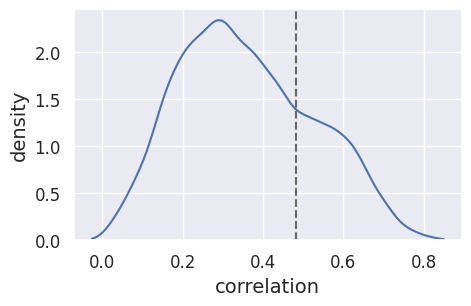

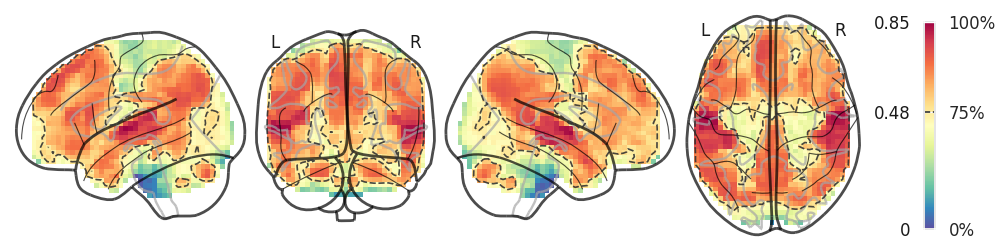

In [16]:
########################################## Using reliable voxels: best 25% voxels ##########################################

n_trials_split = 10
filename = 'corr_group_split_{}trials.gz'.format(n_trials_split)
corr_split = joblib.load(filename)
corr_split_mean = np.mean(corr_split, axis=0)

is_voxel_reliable = corr_split_mean > np.percentile(corr_split_mean, 75)

#### rv for reliable voxels

# mean correlation for each voxel, for each model, using best layer for each voxel
# n_models x n_voxels
corr_voxels_models_rv = np.array([np.max(corr_layers_voxels[:,is_voxel_reliable], axis=0)
                                  for corr_layers_voxels in corr_layers_voxels_models])

# mean correlation for each model, using best layer for each voxel, averaged over all voxels
# n_voxels
corr_models_rv = np.array([np.mean(corr_voxels[is_voxel_reliable]) for corr_voxels in corr_voxels_models])

# mean correlation for each layer of each model, averaged over all voxels
# n_models x n_layers 
corr_layers_models_rv = [np.mean(corr_layers[:, is_voxel_reliable], axis=1) for corr_layers in corr_layers_voxels_models]

# restrict to left and right hemisphere
# n_models x n_voxels//2
corr_l_models_rv = corr_l_models[:,is_voxel_reliable[:n_voxels//2]]
corr_r_models_rv = corr_r_models[:,is_voxel_reliable[n_voxels//2:]]

fh = plt.figure(figsize=(5,3))
ax = plt.subplot(111)
sns.kdeplot(corr_split_mean, cut=0., ax=ax)
plt.axvline(np.percentile(corr_split_mean, 75), ls='--', c='0.4');
plt.xlabel('correlation')
plt.ylabel('density')
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'reliable_voxels_distribution.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

imgtmp = nifti_masker.inverse_transform(corr_split_mean)
fh = plt.figure(figsize=(12,3))
ax = plt.subplot(111)
display = plotting.plot_glass_brain(imgtmp, threshold=0., display_mode='lyrz', 
                          vmin=0., cmap='Spectral_r', 
                          plot_abs=True, colorbar=True, axes=ax)
display.add_contours(imgtmp, levels=[np.percentile(corr_split_mean, 75)], colors='0.2', linewidths=1.2, alpha=0.9, linestyles='dashed')

display._colorbar_ax.set_yticks([0., np.percentile(corr_split_mean, 75), np.max(corr_split_mean)])
ylim = display._colorbar_ax.get_ylim()  
ax2 = display._colorbar_ax.twinx()
ax2.set_ylim(ylim)
ax2.set_yticks([0., np.percentile(corr_split_mean, 75), np.max(corr_split_mean)], ['0%', '75%', '100%'])
ax2.yaxis.set_tick_params(width=0)
#display._cbar._
ax2.axhline(np.percentile(corr_split_mean, 75), ls='--', lw=1.2, color='0.2')

plotting.show() 

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'reliable_voxels_75.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

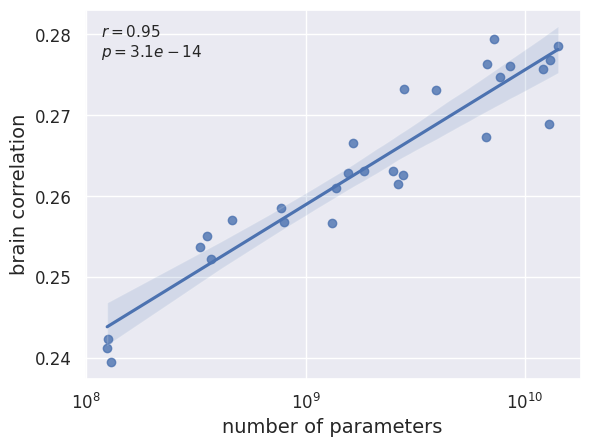

In [17]:
fh = plot_xy(n_parameters, corr_models, 
             xlabel='number of parameters', ylabel='brain correlation', 
             logx=True)
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_params_corr.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

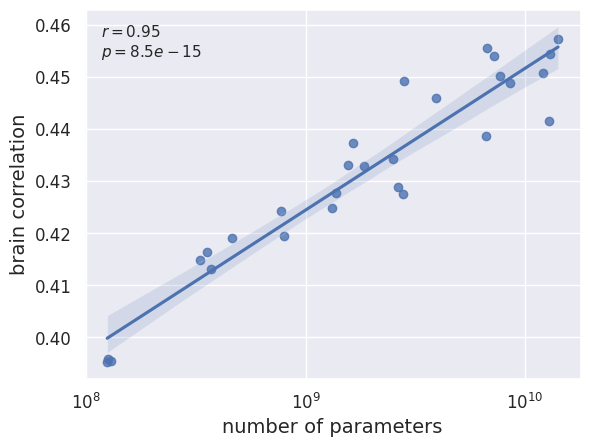

In [18]:
fh = plot_xy(n_parameters, corr_models_rv, 
             xlabel='number of parameters', ylabel='brain correlation', 
             logx=True)
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_params_corr_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

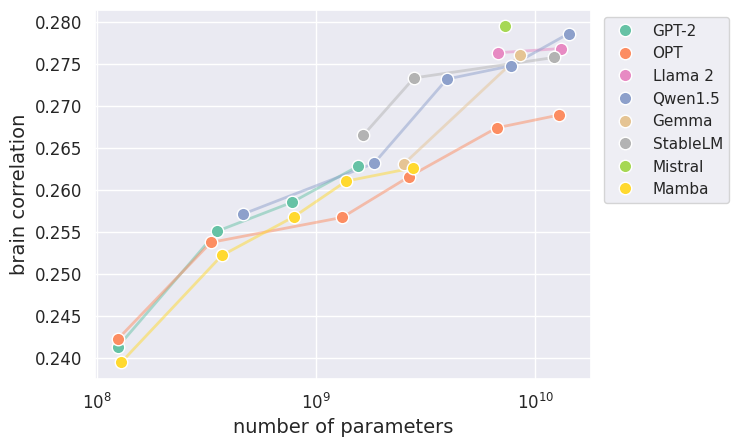

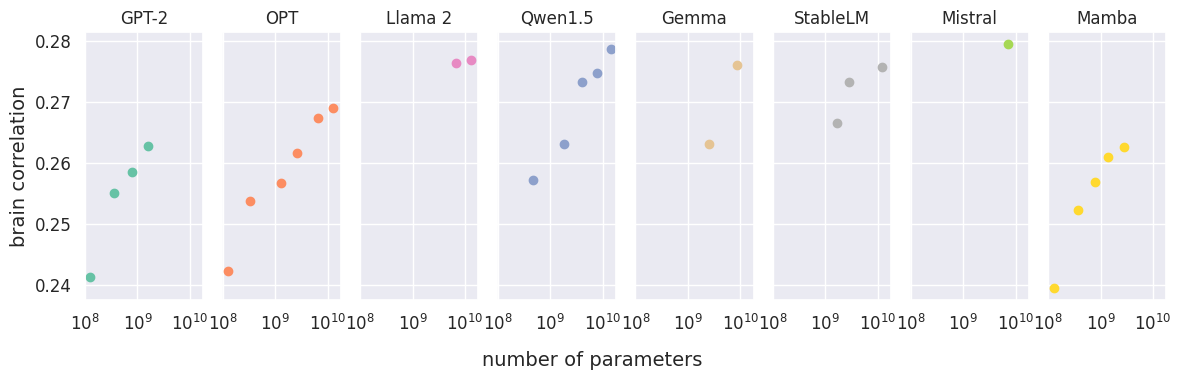

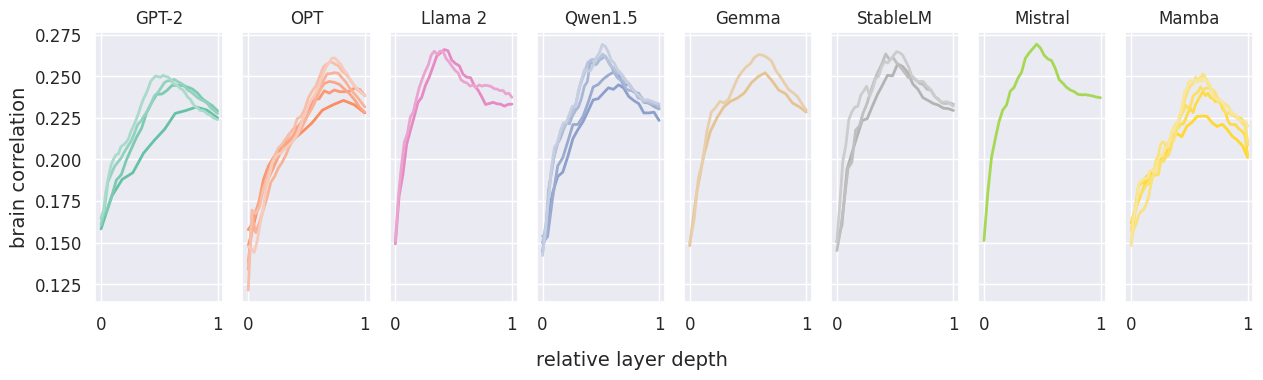

In [19]:
fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
for family in title_family:
    plt.plot(list(n_parameters_family[family].values()), 
             corr_family[family].values(), '-', 
             c=colors_family[family], lw=2, alpha=0.5)            
for family in title_family:
    plt.plot(list(n_parameters_family[family].values()), 
             corr_family[family].values(), 'o', 
             c=colors_family[family],
             markeredgecolor='1.0', markersize=9, label=title_family[family])
ax.set_xscale('log')    
ax.set_xlabel('number of parameters')      
ax.set_ylabel('brain correlation')
plt.legend(bbox_to_anchor=(1.01,1), loc='upper left')
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_params_corr_family.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

fh = plot_xy_family(n_parameters_family, corr_family, 
                    xlabel='number of parameters', ylabel='brain correlation', 
                    logx=True)
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_params_corr_byfamily.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

# as a function of number of parameters, per family
fh, axes = plt.subplots(1, len(title_family), figsize=(6.4*2,4.8*3/4), sharex=True, sharey=True)
for ax, family in zip(axes, title_family):
    for color, n_layers, corr_layers in zip(colors_layers_family[family],
                                     n_layers_family[family].values(), 
                                     corr_layers_family[family].values()):
        ax.plot(np.linspace(0, 1, n_layers), corr_layers, 
                lw=2, ls='-', c=color);
    ax.set_title(title_family[family])    
axes[0].set_ylabel('brain correlation')
fh.text(0.5, -0.04, 'relative layer depth', ha='center', fontsize=14)
plt.tight_layout()
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_params_corr_byfamily_layers.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

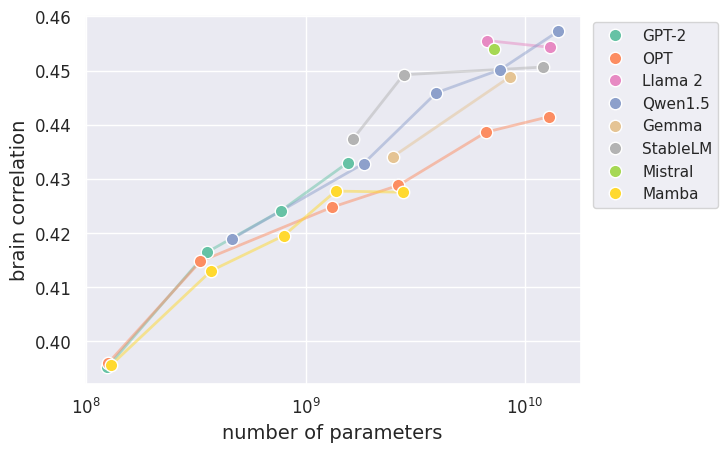

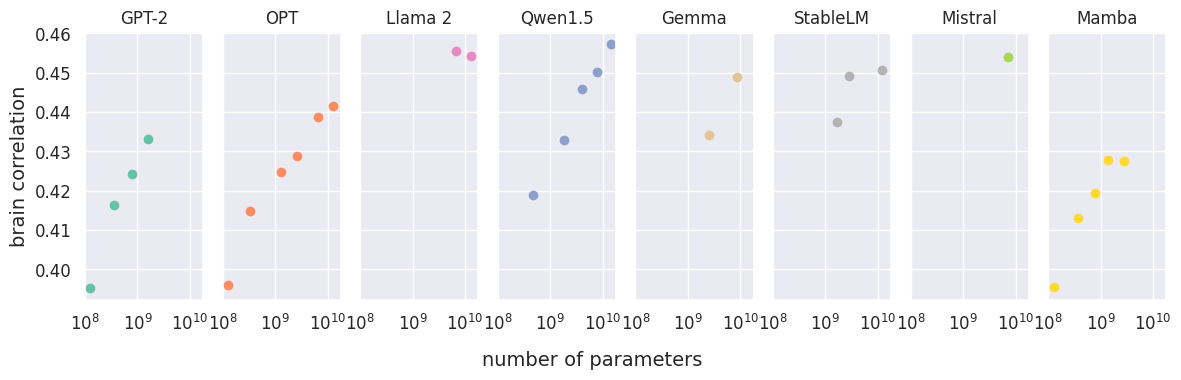

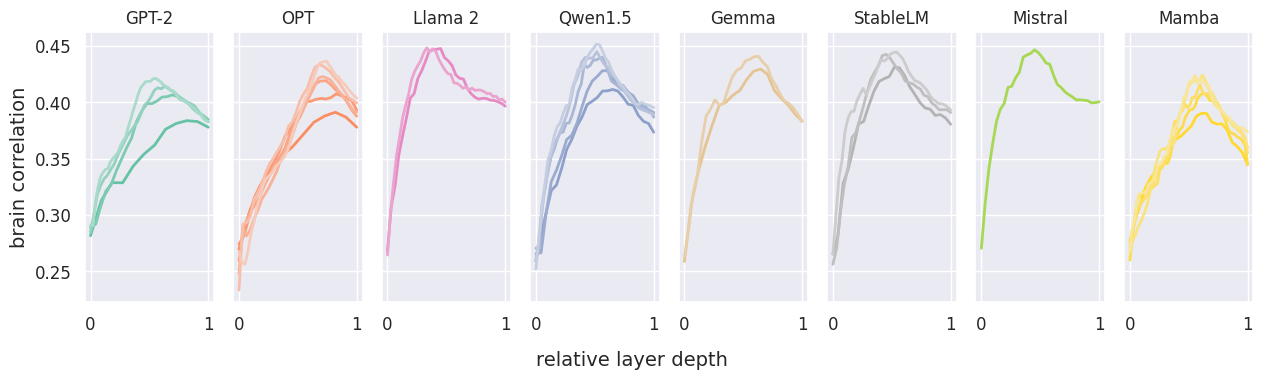

In [20]:
corr_family_rv = {family:{} for family in id_family.keys()}
for corr, model_name in zip(corr_models_rv, model_names):
    corr_family_rv[model_name[0:3]][model_name] = corr

corr_layers_family_rv = {family:{} for family in id_family.keys()}
for corr_layers, model_name in zip(corr_layers_models_rv, model_names):
    corr_layers_family_rv[model_name[0:3]][model_name] = corr_layers

fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
for family in title_family:
    plt.plot(list(n_parameters_family[family].values()), 
             corr_family_rv[family].values(), '-', 
             c=colors_family[family], lw=2, alpha=0.5)
for family in title_family:
    plt.plot(list(n_parameters_family[family].values()), 
             corr_family_rv[family].values(), 'o', 
             c=colors_family[family],
             markeredgecolor='1.0', markersize=9, label=title_family[family])
ax.set_xscale('log')    
ax.set_xlabel('number of parameters')      
ax.set_ylabel('brain correlation')
plt.legend(bbox_to_anchor=(1.01,1), loc='upper left')
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_params_corr_family_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

fh = plot_xy_family(n_parameters_family, corr_family_rv, 
                    xlabel='number of parameters', ylabel='brain correlation', 
                    logx=True)
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_params_corr_byfamily_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

# as a function of number of parameters, per family
fh, axes = plt.subplots(1, len(title_family), figsize=(6.4*2,4.8*3/4), sharex=True, sharey=True)
for ax, family in zip(axes, title_family):
    for color, n_layers, corr_layers in zip(colors_layers_family[family],
                                     n_layers_family[family].values(), 
                                     corr_layers_family_rv[family].values()):
        ax.plot(np.linspace(0, 1, n_layers), corr_layers, 
                lw=2, ls='-', c=color);
    ax.set_title(title_family[family])    
axes[0].set_ylabel('brain correlation')
fh.text(0.5, -0.04, 'relative layer depth', ha='center', fontsize=14)
plt.tight_layout()
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_params_corr_byfamily_layers_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

In [21]:
################################ baselines ################################

# look at random vectors
corr_random_300 = []
for seed in range(1,11):
    model_name ='random_vector_300d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_random_300.append(corr)
corr_random_300 = np.mean(corr_random_300, axis=0)

corr_random_1024 = []
for seed in range(1,11):
    model_name ='random_vector_1024d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_random_1024.append(corr)
corr_random_1024 = np.mean(corr_random_1024, axis=0)

# look at random embeddings
corr_random_emb_300 = []
for seed in range(1,11):
    model_name ='random_embedding_300d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_random_emb_300.append(corr)
corr_random_emb_300 = np.mean(corr_random_emb_300, axis=0)

corr_random_emb_1024 = []
for seed in range(1,11):
    model_name ='random_embedding_1024d_seed{}'.format(seed)
    filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
    with open(filename, 'rb') as f:
        corr = joblib.load(f)
    corr_random_emb_1024.append(corr)
corr_random_emb_1024 = np.mean(corr_random_emb_1024, axis=0)

# GloVe
model_name ='glove'
filename = os.path.join(glm_folder, '{}_layer-{}_corr.gz'.format(model_name, 0))
with open(filename, 'rb') as f:
    corr_glove = joblib.load(f)

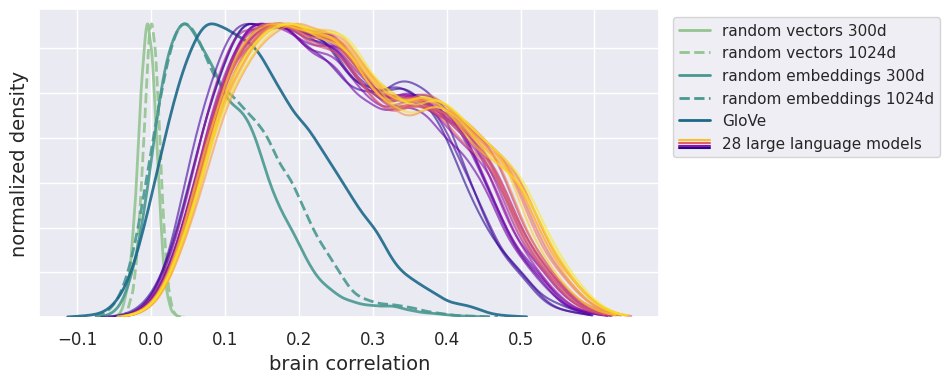

In [22]:
color_baseline = sns.color_palette('crest', n_colors=15)[::5]

class MyLegendHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        lines = []
        n_models = len(color_models[::8])
        for i, color in enumerate(color_models[::8]):
             lines.append(plt.Line2D([x0,y0+width], 
                               [i/n_models*height,i/n_models*height], 
                               color=color))
        return lines

fh = plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
sns.kdeplot(corr_random_300, c=color_baseline[0], lw=2, alpha=0.9, cut=0., ax=ax);
#ax.set_yticks([])
ax.set_yticklabels([])
ax.tick_params(axis='y', length=0)
plt.xlabel('brain correlation')
plt.ylabel('normalized density')
ax = plt.twinx()
sns.kdeplot(corr_random_1024, c=color_baseline[0], ls='--', lw=2, alpha=0.9, cut=0.);
ax.grid(None)
ax.axis('off')
ax = plt.twinx()
sns.kdeplot(corr_random_emb_300, c=color_baseline[1], lw=2, alpha=0.9, cut=0.);
ax.grid(None)
ax.axis('off')
ax = plt.twinx()
sns.kdeplot(corr_random_emb_1024, c=color_baseline[1], ls='--', lw=2, alpha=0.9, cut=0.);
ax.grid(None)
ax.axis('off')
ax = plt.twinx()
sns.kdeplot(corr_glove, c=color_baseline[2], lw=2, alpha=0.9, cut=0.);
ax.grid(None)
ax.axis('off')
for corr_voxels, color in zip(corr_voxels_models, color_models):
    ax = plt.twinx()
    sns.kdeplot(corr_voxels, color=color, lw=1.5, alpha=0.6, cut=0.);
    ax.grid(None)
    ax.axis('off')

plt.plot([0], c=color_baseline[0], lw=2, label='random vectors 300d')
plt.plot([0], c=color_baseline[0], lw=2, ls='--', label='random vectors 1024d')
plt.plot([0], c=color_baseline[1], lw=2, label='random embeddings 300d')
plt.plot([0], c=color_baseline[1], lw=2, ls='--', label='random embeddings 1024d')
plt.plot([0], c=color_baseline[2], lw=2, label='GloVe')

hllm, = plt.plot([0], label='28 large language models')

ax.tick_params(axis='y', labelleft='off')

plt.legend(handler_map={hllm: MyLegendHandler()}, bbox_to_anchor=(1.01,1), loc='upper left')

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'distribution_correlation_models_baselines.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

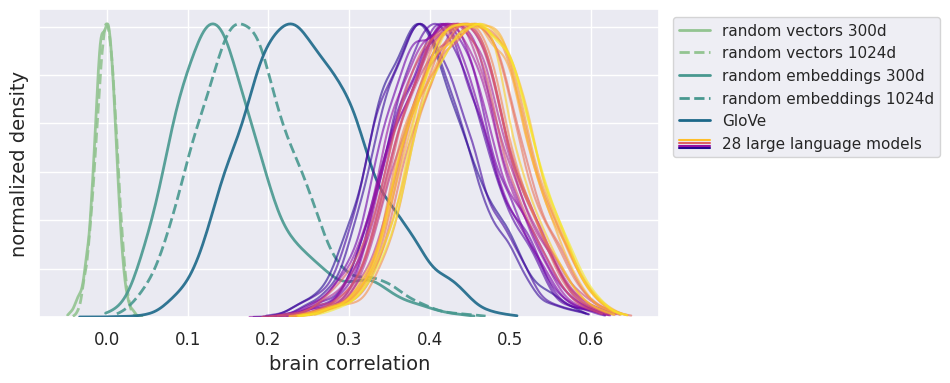

In [23]:
fh = plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
sns.kdeplot(corr_random_300[is_voxel_reliable], c=color_baseline[0], lw=2, alpha=0.9, cut=0., ax=ax);
ax.set_yticklabels([])
ax.tick_params(axis='y', length=0)
plt.xlabel('brain correlation')
plt.ylabel('normalized density')
ax = plt.twinx()
sns.kdeplot(corr_random_1024[is_voxel_reliable], c=color_baseline[0], ls='--', lw=2, alpha=0.9, cut=0., ax=ax);
ax.grid(None)
ax.axis('off')
ax = plt.twinx()
sns.kdeplot(corr_random_emb_300[is_voxel_reliable], c=color_baseline[1], lw=2, alpha=0.9, cut=0., ax=ax);
ax.grid(None)
ax.axis('off')
ax = plt.twinx()
sns.kdeplot(corr_random_emb_1024[is_voxel_reliable], c=color_baseline[1], ls='--', lw=2, alpha=0.9, cut=0., ax=ax);
ax.grid(None)
ax.axis('off')
ax = plt.twinx()
sns.kdeplot(corr_glove[is_voxel_reliable], c=color_baseline[2], lw=2, alpha=0.9, cut=0., ax=ax);
ax.grid(None)
ax.axis('off')
for corr_voxels, color in zip(corr_voxels_models, color_models):
    ax = plt.twinx()
    sns.kdeplot(corr_voxels[is_voxel_reliable], color=color, lw=1.5, alpha=0.6, cut=0., ax=ax);
    ax.grid(None)
    ax.axis('off')

plt.plot([0], c=color_baseline[0], lw=2, label='random vectors 300d')
plt.plot([0], c=color_baseline[0], lw=2, ls='--', label='random vectors 1024d')
plt.plot([0], c=color_baseline[1], lw=2, label='random embeddings 300d')
plt.plot([0], c=color_baseline[1], lw=2, ls='--', label='random embeddings 1024d')
plt.plot([0], c=color_baseline[2], lw=2, label='GloVe')

hllm, = plt.plot([0], label='28 large language models')

ax.tick_params(axis='y', labelleft='off')

plt.legend(handler_map={hllm: MyLegendHandler()}, bbox_to_anchor=(1.01,1), loc='upper left')

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'distribution_correlation_models_baselines_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

Qwen1.5-14B


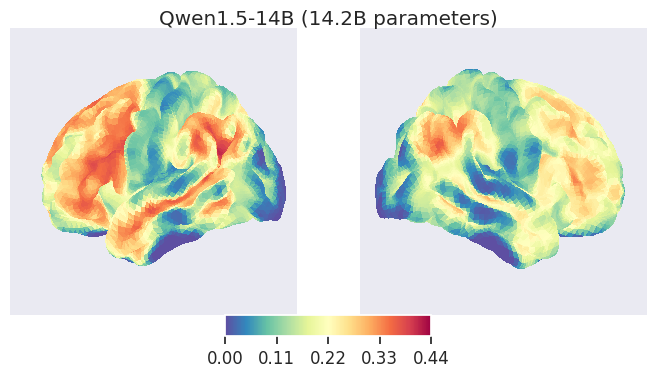

gpt2


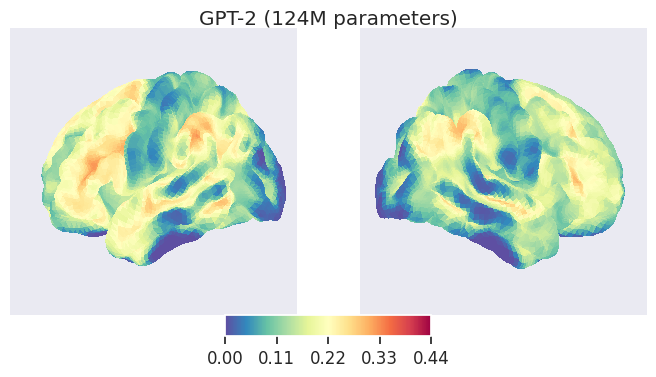

In [24]:
######## best model ########
idx_best_model = np.argmax(corr_models_rv)

print(model_names[idx_best_model])

corr_voxels = corr_voxels_models[idx_best_model]

imgtmp = nifti_masker.inverse_transform(corr_voxels - corr_random_emb_1024)

vmax = np.max(corr_voxels - corr_random_emb_1024)

fh, axes = plotting.plot_img_on_surf(imgtmp,
                                     surf_mesh='fsaverage5',
                                     views=['lateral'],
                                     hemispheres=['left', 'right'],
                                     vmin=0., vmax=vmax,
                                     cmap='Spectral_r',
                                     symmetric_cbar=False,
                                     cbar_tick_format='%.2f',
                                     colorbar=True,
                                     title='Qwen1.5-14B (14.2B parameters)')
for ax in axes[0:2]:
    ax.set_box_aspect(None, zoom=1.45)
fh.set_size_inches(7, 4.3)
plotting.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'brain_best_over_random_emb.pdf'), bbox_inches='tight', 
               transparent=True, facecolor=(1,1,1,0))
    
######## worst model ########
idx_worst_model = np.argmin(corr_models_rv)

print(model_names[idx_worst_model])

corr_voxels = corr_voxels_models[idx_worst_model]

imgtmp = nifti_masker.inverse_transform(corr_voxels - corr_random_emb_1024)

fh, axes = plotting.plot_img_on_surf(imgtmp,
                                     surf_mesh='fsaverage5',
                                     views=['lateral'],
                                     hemispheres=['left', 'right'],
                                     vmin=0., vmax=vmax,
                                     cmap='Spectral_r',
                                     symmetric_cbar=False,
                                     cbar_tick_format='%.2f',
                                     colorbar=True,
                                     title='GPT-2 (124M parameters)')
for ax in axes[0:2]:
    ax.set_box_aspect(None, zoom=1.45)
fh.set_size_inches(7, 4.3)
plotting.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'brain_worst_over_random_emb.pdf'), bbox_inches='tight', 
               transparent=True, facecolor=(1,1,1,0))    

In [25]:
################################ L/R Asymmetries ################################
# whole brain

#l r asym in baselines
for corr_voxels in [corr_random_300, corr_random_1024,
                    corr_random_emb_300, corr_random_emb_1024,
                    corr_glove]:
    print(corr_voxels[:n_voxels//2].mean() - corr_voxels[n_voxels//2:].mean())

-0.0007365405679954648
0.00026807975656389563
-0.010467729278850715
-0.008450554201932983
-0.003250355732245025


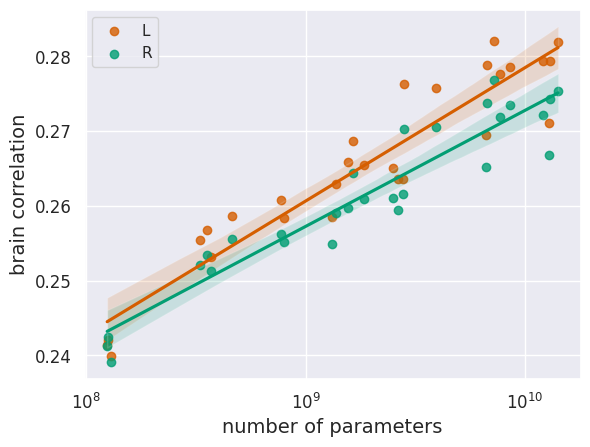

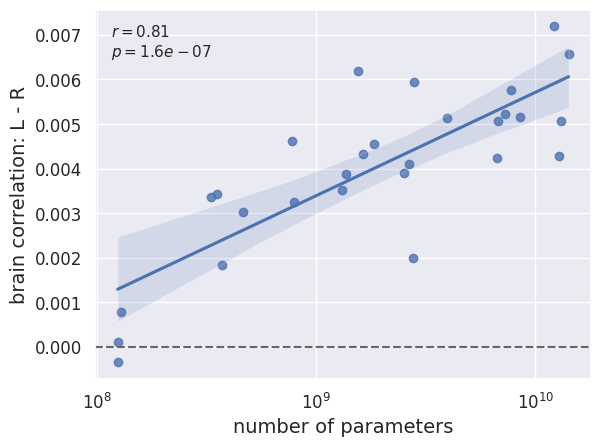

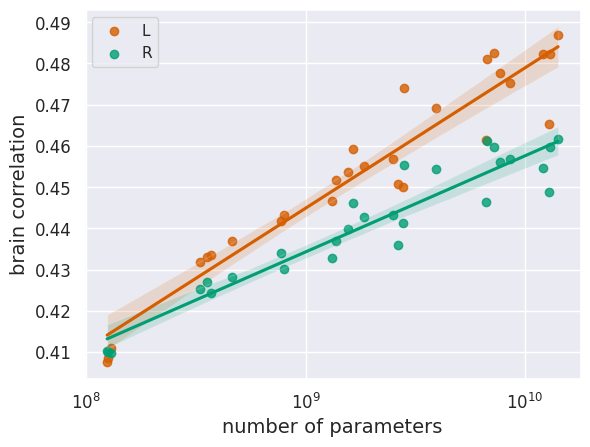

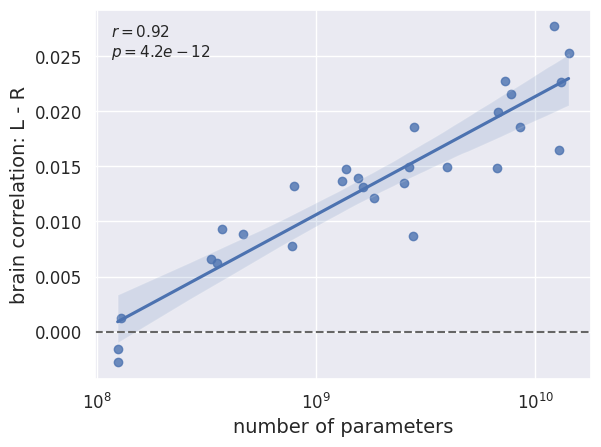

In [26]:
fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=n_parameters, 
            y=np.mean(corr_l_models, axis=1),
            logx=True, ax=ax, label='L', color=l_r_colors[0]);
sns.regplot(x=n_parameters, 
            y=np.mean(corr_r_models, axis=1),
            logx=True, ax=ax, label='R', color=l_r_colors[1]);
ax.set_xscale('log')
ax.set_xlabel('number of parameters')      
ax.set_ylabel('brain correlation')
plt.legend()
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_r_all_mean.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=n_parameters, 
            y=np.mean(corr_l_models, axis=1)-np.mean(corr_r_models, axis=1), 
            logx=True, ax=ax);
ax.set_xscale('log')
ax.set_xlabel('number of parameters')      
ax.set_ylabel('brain correlation: L - R')
ax.axhline(0., ls='--', c='0.4', zorder=1);
r, p = pearsonr(np.log(n_parameters), (np.mean(corr_l_models, axis=1)
                                      -np.mean(corr_r_models, axis=1)))
fh.text(0.15, 0.85,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
        ha='left', va='top', fontsize=11)
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_minus_r_all.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=n_parameters, 
            y=np.percentile(corr_l_models, 90, axis=1),
            logx=True, ax=ax, label='L', color=l_r_colors[0]);
sns.regplot(x=n_parameters, 
            y=np.percentile(corr_r_models, 90, axis=1),
            logx=True, ax=ax, label='R', color=l_r_colors[1]);
ax.set_xscale('log')
ax.set_xlabel('number of parameters')      
ax.set_ylabel('brain correlation')
plt.legend()
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_r_all_90.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=n_parameters, 
            y=np.percentile(corr_l_models, 90, axis=1)-np.percentile(corr_r_models, 90, axis=1),
            logx=True, ax=ax);
ax.set_xscale('log')
ax.set_xlabel('number of parameters')      
ax.set_ylabel('brain correlation: L - R')
ax.axhline(0., ls='--', c='0.4', zorder=1);
r, p = pearsonr(np.log(n_parameters), (np.percentile(corr_l_models, 90, axis=1)
                                      -np.percentile(corr_r_models, 90, axis=1)))
fh.text(0.15, 0.85,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
        ha='left', va='top', fontsize=11)
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_minus_r_all_90.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

In [27]:
# on the most 25% reliable voxels

#l r asym in baselines
for corr_voxels in [corr_random_300, corr_random_1024,
                    corr_random_emb_300, corr_random_emb_1024,
                    corr_glove]:
    print(corr_voxels[:n_voxels//2][is_voxel_reliable[:n_voxels//2]].mean()
          - corr_voxels[n_voxels//2:][is_voxel_reliable[n_voxels//2:]].mean())

-0.002464196720898963
-0.00048075726748397535
-0.027944305523703555
-0.02255753676236741
-0.0006147624145502184


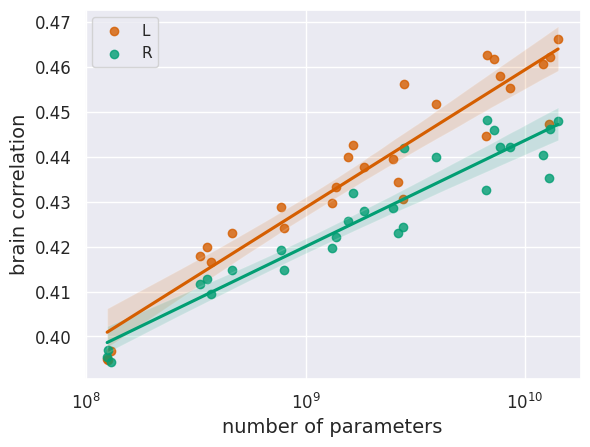

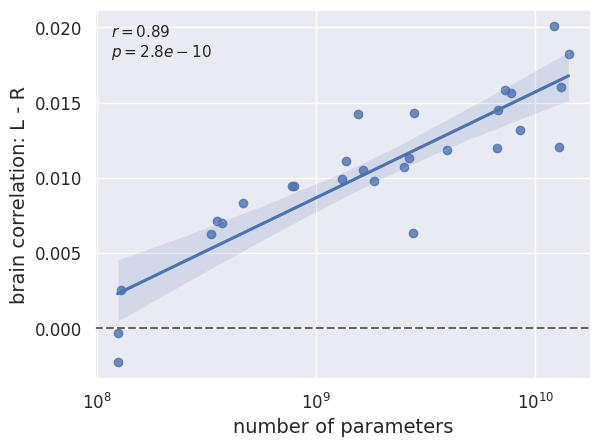

In [28]:
fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=n_parameters, 
            y=np.mean(corr_l_models_rv, axis=1),
            logx=True, ax=ax, label='L', color=l_r_colors[0]);
sns.regplot(x=n_parameters, 
            y=np.mean(corr_r_models_rv, axis=1),
            logx=True, ax=ax, label='R', color=l_r_colors[1]);
ax.set_xscale('log')
ax.set_xlabel('number of parameters')      
ax.set_ylabel('brain correlation')
plt.legend()
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_r_all_mean_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

fh = plt.figure(figsize=(6.4, 4.8))
ax = plt.subplot(111)
sns.regplot(x=n_parameters, 
            y=(np.mean(corr_l_models_rv, axis=1)
               -np.mean(corr_r_models_rv, axis=1)), 
            logx=True, ax=ax);
ax.set_xscale('log')
ax.set_xlabel('number of parameters')      
ax.set_ylabel('brain correlation: L - R')
ax.axhline(0., ls='--', c='0.4', zorder=1);
r, p = pearsonr(np.log(n_parameters), (np.mean(corr_l_models_rv, axis=1)
                                      -np.mean(corr_r_models_rv, axis=1)))
fh.text(0.15, 0.85,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
        ha='left', va='top', fontsize=11)
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'l_minus_r_all_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

7.275510762638933


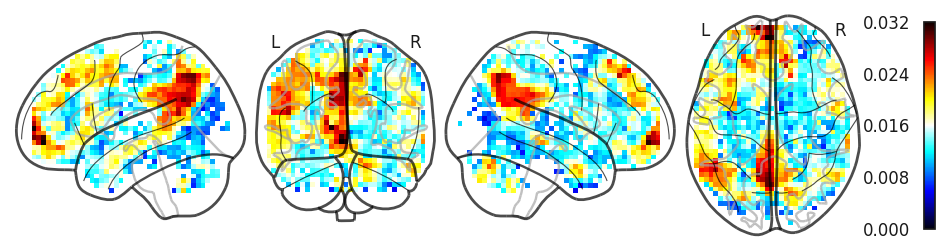

In [29]:
################################ Slopes, voxelwise ################################
slopes = []
tvalues = []
pvalues = []
for idx_voxel in range(n_voxels):
    y = corr_voxels_models[:,idx_voxel]
    x = np.log(n_parameters)
    x = sm.add_constant(x)
    lm = sm.OLS(y, x)
    res = lm.fit()
    slopes.append(res.params[1])
    tvalues.append(res.tvalues[1])
    pvalues.append(res.pvalues[1])

slopes = np.array(slopes)
tvalues = np.array(tvalues)
pvalues = np.array(pvalues)

vtmp = slopes.copy()
p_thsld = 10**-7
t_thsld = np.abs(scipy.stats.t.ppf(p_thsld/2, df=n_models-2)) #two-sided
print(t_thsld)
vtmp[np.abs(tvalues) < t_thsld] = np.nan
imgtmp = nifti_masker.inverse_transform(vtmp)

fh = plt.figure(figsize=(12,3))
ax = plt.subplot(111)
plotting.plot_glass_brain(imgtmp, threshold=0., display_mode='lyrz', cbar_tick_format='%.3f',
                          plot_abs=False, colorbar=True, axes=ax)
plotting.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'glassbrain_slopes.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

In [30]:
################################ ROIs analysis ################################

roi_names = ['TP', 'aSTS', 'pSTS', 'AG_TPJ', 'BA44', 'BA45', 'BA47']
n_rois = len(roi_names)
folder_mask = 'roi_masks'

roi_list = [os.path.join(folder_mask, '{}.nii.gz'.format(roi_name)) for roi_name in roi_names]
roi_list_r = [swap_img_hemispheres(roi_mask) for roi_mask in roi_list]
rois_t = nifti_masker.transform(roi_list + roi_list_r)
idx_rois = [np.flatnonzero(roi_t == 1.0) for roi_t in rois_t]

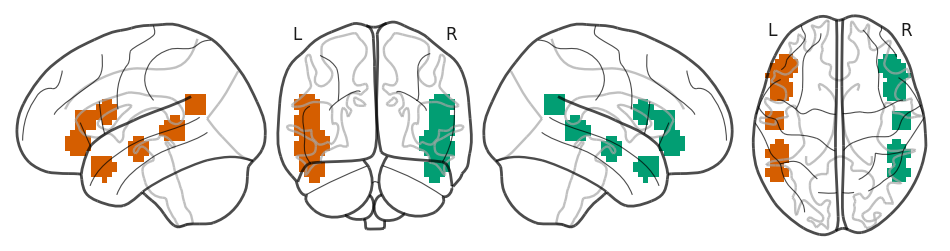

In [31]:
cmap = ListedColormap(l_r_colors)

fh = plt.figure(figsize=(12,3))
ax = plt.subplot(111)
for vtmp in rois_t[:n_rois]:
    imgtmp = nifti_masker.inverse_transform(-vtmp)
    plotting.plot_glass_brain(imgtmp, display_mode='lyrz', cmap=cmap, axes=ax, alpha=0.)
for vtmp in rois_t[n_rois:]:
    imgtmp = nifti_masker.inverse_transform(vtmp)
    plotting.plot_glass_brain(imgtmp, display_mode='lyrz', cmap=cmap, axes=ax, alpha=0.)
plotting.plot_glass_brain(None,  display_mode='lyrz', axes=ax)
plt.show()
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'rois_l_r.pdf'), bbox_inches='tight', transparent=True)
    fh.savefig(os.path.join(fig_folder, 'rois_l_r.svg'), bbox_inches='tight', transparent=True)

TP 	 7.1e-02 	 ns
aSTS 	 5.2e-10 	 ***
pSTS 	 7.3e-09 	 ***
AG_TPJ 	 2.5e-20 	 ***
BA44 	 5.3e-01 	 ns
BA45 	 9.3e-07 	 ***
BA47 	 1.1e-04 	 ***


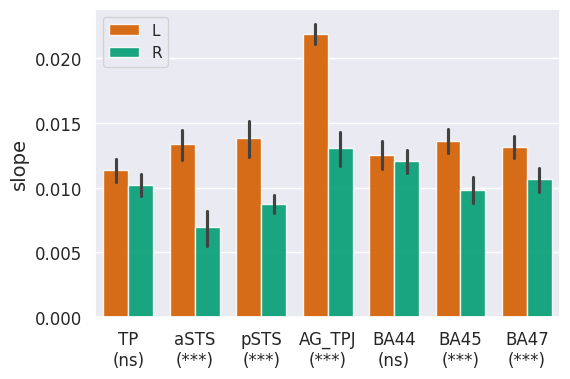

In [32]:
df_roi_slopes = []
for idx_roi, roi_name in zip(idx_rois[0:n_rois], roi_names):
    df_roi_slopes.append(pd.DataFrame({'roi':roi_name,
                  'slope':slopes[idx_roi],
                  'hemi':'L'}))
for idx_roi, roi_name in zip(idx_rois[n_rois:], roi_names):
    df_roi_slopes.append(pd.DataFrame({'roi':roi_name,
                  'slope':slopes[idx_roi],
                  'hemi':'R'}))
df_roi_slopes = pd.concat(df_roi_slopes)

xtickslabels_roi = []
for roi_name in roi_names:
    ttest = ttest_ind(df_roi_slopes[(df_roi_slopes['roi']==roi_name)&(df_roi_slopes['hemi']=='L')].slope,
              df_roi_slopes[(df_roi_slopes['roi']==roi_name)&(df_roi_slopes['hemi']=='R')].slope)
    print(roi_name, '\t', 
          '{:.01e}'.format(ttest.pvalue), '\t', pvalue2str(ttest.pvalue))
    xtickslabels_roi.append('{}\n({})'.format(roi_name, pvalue2str(ttest.pvalue)))

fh = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)
sns.barplot(data=df_roi_slopes, x='roi', y='slope', hue='hemi', 
            palette=l_r_colors, saturation=1.0, width=0.75, alpha=0.9,
            ax=ax)
plt.legend(loc='upper left')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(xtickslabels_roi)
ax.set_xlabel('')
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'rois_slopes.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

TP 	 0.32 	 9.5e-02
aSTS 	 0.84 	 3.1e-08
pSTS 	 0.81 	 2.0e-07
AG_TPJ 	 0.85 	 1.3e-08
BA44 	 0.13 	 5.2e-01
BA45 	 0.73 	 1.1e-05
BA47 	 0.52 	 4.1e-03


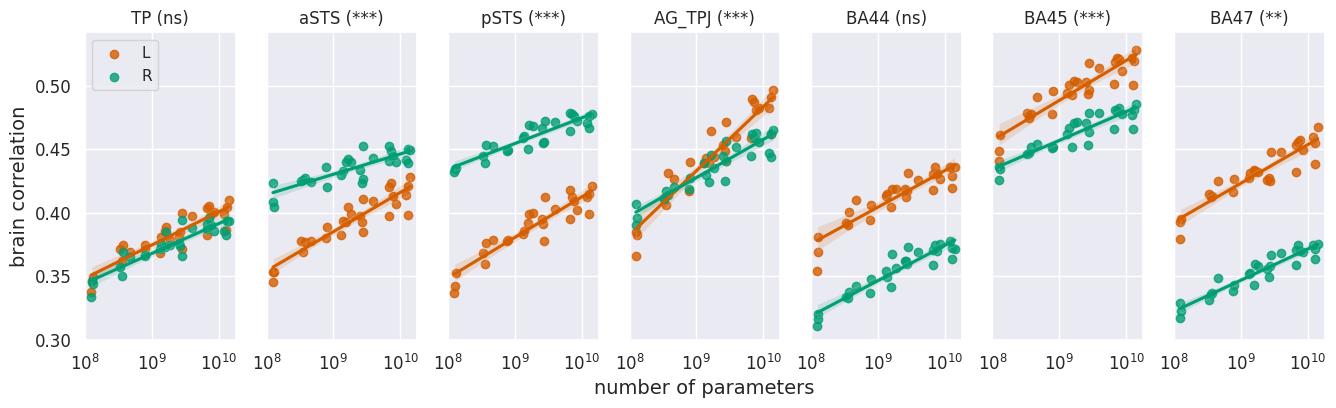

In [33]:
fh, axes = plt.subplots(1, n_rois, figsize=(16,4), sharey=True)
for i, (idx_roi_l, idx_roi_r, roi_name) in enumerate(zip(idx_rois[:n_rois], idx_rois[n_rois:], roi_names)):
    ax = axes[i]
    sns.regplot(x=n_parameters, 
                y=np.mean(corr_voxels_models[:,idx_roi_l], axis=1),
                logx=True, color=l_r_colors[0], ax=ax, label='L');   
    sns.regplot(x=n_parameters, 
                y=np.mean(corr_voxels_models[:,idx_roi_r], axis=1),
                logx=True, color=l_r_colors[1], ax=ax, label='R');   
    ax.set_xscale('log')

    r, p = pearsonr(np.log(n_parameters), 
                 (np.mean(corr_voxels_models[:,idx_roi_l], axis=1)
                  -np.mean(corr_voxels_models[:,idx_roi_r], axis=1)))
    print(roi_name, '\t', '{:.2f}'.format(r), '\t', '{:.1e}'.format(p))
    ax.set_title('{} ({})'.format(roi_name, pvalue2str(p)))

    
axes[n_rois//2].set_xlabel('number of parameters')      
axes[0].set_ylabel('brain correlation')
axes[0].legend(loc='upper left')
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'rois_l_r_corr.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

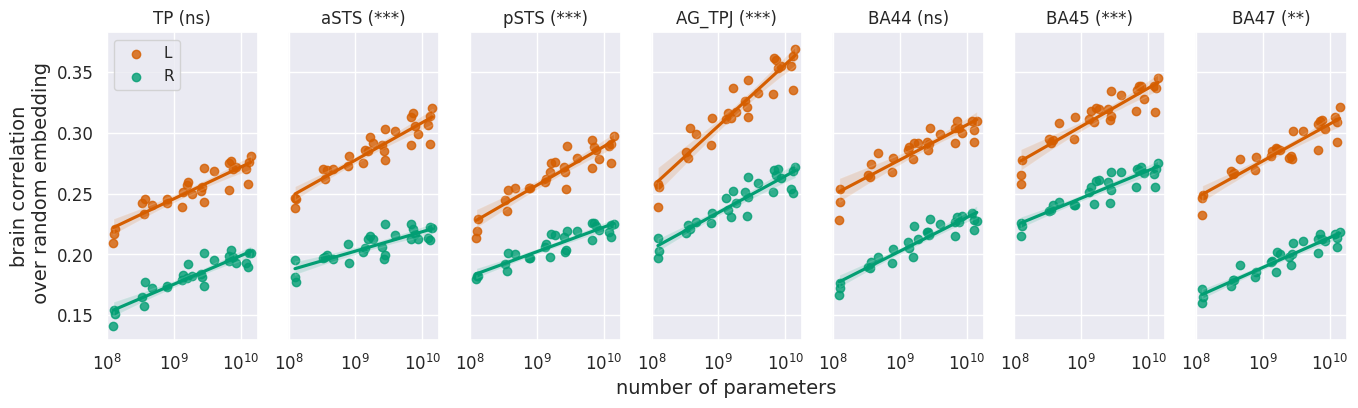

In [34]:
corr_random = corr_random_emb_1024
fh, axes = plt.subplots(1, n_rois, figsize=(16,4), sharey=True)
for i, (idx_roi_l, idx_roi_r, roi_name) in enumerate(zip(idx_rois[:n_rois], idx_rois[n_rois:], roi_names)):
    ax = axes[i]
    sns.regplot(x=n_parameters, 
                y=np.mean(corr_voxels_models[:,idx_roi_l] - corr_random[idx_roi_l], axis=1),
                logx=True, color=l_r_colors[0], ax=ax, label='L'); 
    sns.regplot(x=n_parameters, 
                y=np.mean(corr_voxels_models[:,idx_roi_r] - corr_random[idx_roi_r], axis=1),
                logx=True, color=l_r_colors[1], ax=ax, label='R'); 
    ax.set_xscale('log')
    ax.set_title(roi_name)
    
    r, p = pearsonr(np.log(n_parameters), 
                 (np.mean(corr_voxels_models[:,idx_roi_l], axis=1)
                  -np.mean(corr_voxels_models[:,idx_roi_r], axis=1)))
    ax.set_title('{} ({})'.format(roi_name, pvalue2str(p)))
    
axes[n_rois//2].set_xlabel('number of parameters')      
axes[0].set_ylabel('brain correlation\n over random embedding')
axes[0].legend(loc='upper left')

plt.show()


if save_fig:
    fh.savefig(os.path.join(fig_folder, 'rois_l_r_corr_over_random.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

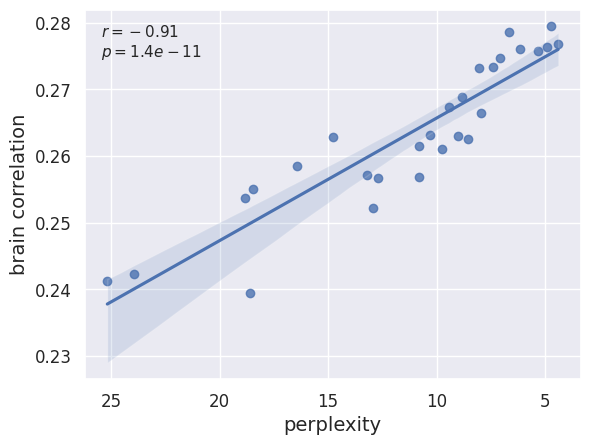

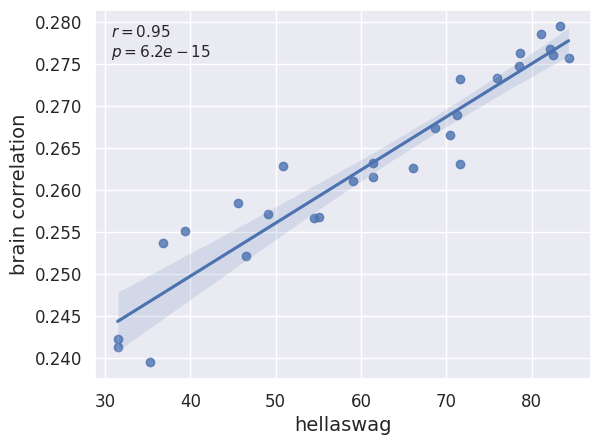

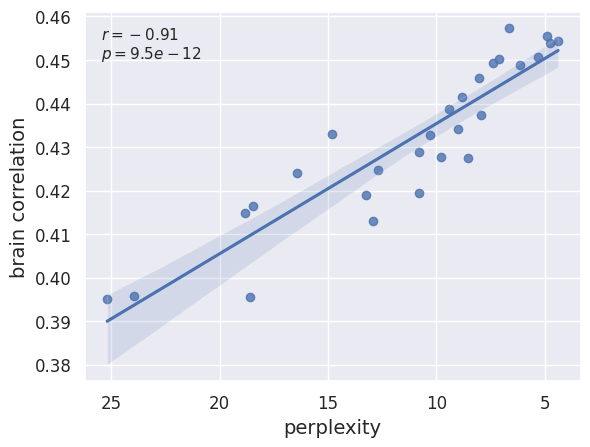

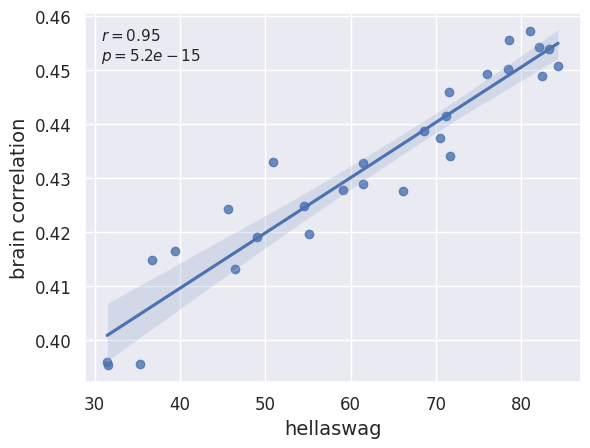

In [35]:
###################### other x-axis: hellaswag, perplexity ######################

fh = plot_xy(ppl_models, corr_models, 'perplexity', 'brain correlation', invert_xaxis=True)
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_ppl_corr.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))
    
fh = plot_xy(hellaswag_models, corr_models, 'hellaswag', 'brain correlation')
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_hellaswag_corr.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

fh = plot_xy(ppl_models, corr_models_rv, 'perplexity', 'brain correlation', invert_xaxis=True)
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_ppl_corr_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))
    
fh = plot_xy(hellaswag_models, corr_models_rv, 'hellaswag', 'brain correlation')
if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_hellaswag_corr_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

In [36]:
######## consider only largest model (10 models out of 28)
params_thsld = 3*10**9
print((n_parameters>params_thsld).sum())

10


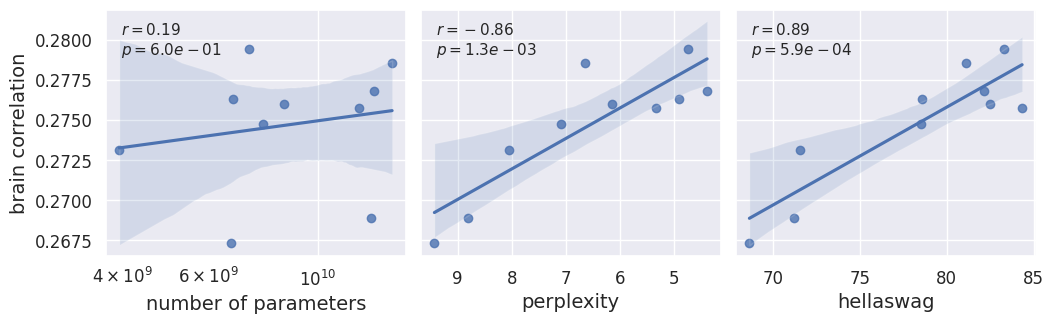

In [37]:
fh, axes = plt.subplots(1, 3, figsize=(12, 3.2), sharex=False, sharey=True)

ax=axes[0]
sns.regplot(x=n_parameters[n_parameters>params_thsld],
            y=corr_models[n_parameters>params_thsld],
            logx=True, ax=ax);
ax.set_xscale('log')
ax.set_xlabel('number of parameters')      
ax.set_ylabel('brain correlation')
r, p = pearsonr(np.log(n_parameters[n_parameters>params_thsld]), 
                corr_models[n_parameters>params_thsld])
ax.text(0.05, 0.95,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
              ha='left', va='top', fontsize=11, transform=ax.transAxes)

ax=axes[1]
sns.regplot(x=ppl_models[n_parameters>params_thsld],
            y=corr_models[n_parameters>params_thsld],
            ax=ax);
ax.invert_xaxis()
ax.set_xlabel('perplexity')
r, p = pearsonr(ppl_models[n_parameters>params_thsld],
                corr_models[n_parameters>params_thsld])
ax.text(0.05, 0.95,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
              ha='left', va='top', fontsize=11, transform=ax.transAxes)

ax=axes[2]
sns.regplot(x=hellaswag_models[n_parameters>params_thsld],
            y=corr_models[n_parameters>params_thsld],
            ax=ax);
ax.set_xlabel('hellaswag')
r, p = pearsonr(hellaswag_models[n_parameters>params_thsld],
                corr_models[n_parameters>params_thsld])
ax.text(0.05, 0.95,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
              ha='left', va='top', fontsize=11, transform=ax.transAxes)

fh.subplots_adjust(wspace=0.05)

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_corr_above3b.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

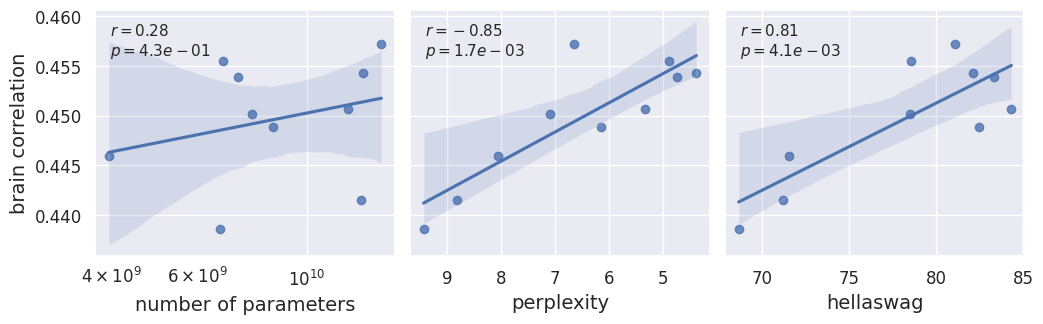

In [38]:
fh, axes = plt.subplots(1, 3, figsize=(12, 3.2), sharex=False, sharey=True)
ax=axes[0]
sns.regplot(x=n_parameters[n_parameters>params_thsld],
            y=corr_models_rv[n_parameters>params_thsld],
            logx=True, ax=ax);
ax.set_xscale('log')
ax.set_xlabel('number of parameters')      
ax.set_ylabel('brain correlation')
r, p = pearsonr(np.log(n_parameters[n_parameters>params_thsld]), 
                corr_models_rv[n_parameters>params_thsld])
ax.text(0.05, 0.95,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
              ha='left', va='top', fontsize=11, transform=ax.transAxes)

ax=axes[1]
sns.regplot(x=ppl_models[n_parameters>params_thsld],
            y=corr_models_rv[n_parameters>params_thsld],
            ax=ax);
ax.invert_xaxis()
ax.set_xlabel('perplexity')    
r, p = pearsonr(ppl_models[n_parameters>params_thsld],
                corr_models_rv[n_parameters>params_thsld])
ax.text(0.05, 0.95,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
              ha='left', va='top', fontsize=11, transform=ax.transAxes)  

ax=axes[2]
sns.regplot(x=hellaswag_models[n_parameters>params_thsld],
            y=corr_models_rv[n_parameters>params_thsld],
            ax=ax);
ax.set_xlabel('hellaswag') 
r, p = pearsonr(hellaswag_models[n_parameters>params_thsld],
                corr_models_rv[n_parameters>params_thsld])
ax.text(0.05, 0.95,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
              ha='left', va='top', fontsize=11, transform=ax.transAxes)

fh.subplots_adjust(wspace=0.05)

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'llms_corr_above3b_rv.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))